In [11]:
import networkx as nx
from matplotlib.pyplot import figure,text
G=nx.Graph()
for i in range(1,16):
    G.add_node(i)

G.add_edge(1,2)
G.add_edge(2,5)
G.add_edge(5,12)
G.add_edge(1,3)
G.add_edge(3,6)
G.add_edge(6,11)
G.add_edge(11,12)
G.add_edge(2,3)
G.add_edge(2,11)
G.add_edge(1,4)
G.add_edge(3,4)
G.add_edge(3,7)
G.add_edge(6,7)
G.add_edge(6,10)
G.add_edge(11,10)
G.add_edge(7,10)
G.add_edge(11,13)
G.add_edge(10,13)
G.add_edge(12,13)
G.add_edge(4,9)
G.add_edge(7,9)
G.add_edge(10,9)
G.add_edge(15,9)
G.add_edge(8,9)
G.add_edge(4,8)
G.add_edge(15,14)
G.add_edge(10,14)
G.add_edge(13,14)
for edge in G.edges():
    G[edge[0]][edge[1]]['capacity']=12*100
    G[edge[0]][edge[1]]['color']='black'
    
G[2][3]['capacity']=48*100
G[2][5]['capacity']=48*100
G[14][15]['capacity']=48*100
G[3][6]['capacity']=48*100
G[6][11]['capacity']=48*100
G[3][7]['capacity']=48*100
G[6][10]['capacity']=48*100
G[11][10]['capacity']=48*100
G[7][10]['capacity']=48*100

for edge in G.edges():
    G[edge[0]][edge[1]]['capacity']/=20

pos = nx.kamada_kawai_layout(G)
edges = G.edges()
colors = [G[u][v]['color'] for u,v in edges]
weights = [G[u][v]['capacity'] for u,v in edges]

node_color_dict={}
for i in G.nodes():
    node_color_dict[i]='b'
node_color_dict[1]='orange'
node_color_dict[5]='orange'
node_color_dict[4]='orange'
node_color_dict[13]='orange'
node_color_dict[2]='orange'
node_color_dict[9]='orange'
node_color_dict[15]='orange'
#plt.figure(3,figsize=(100,100)) 
# nx.draw(G,pos,edge_color=colors, width=weights,with_labels=True,node_size=[40000]*len(G.nodes),node_color=list(node_color_dict.values()))
# for node, (x, y) in pos.items():
#     text(x, y, node, fontsize=200, ha='center', va='center')

import csv

with open(r"C:\Users\HARIHARAN SUBRAMANIA\Desktop\ACTUAL CN PROJ\demands.csv","r") as csv:
    f=csv.read()
f=f[26:].split("\n")
for i in range(len(f)):
    f[i]=f[i].split(",")
DEMAND=[]
PAIR=[]
IEP=[[1,13],[5,9],[4,2],[5,15],[13,2]]
for i in range(4000):
    DEMAND.append(int(f[i][2]))
    pair=tuple((int(f[i][0]),int(f[i][1])))
    for k in range(len(IEP)):
        if tuple(IEP[k])==pair:
            PAIR.append(k)
for i in range(len(DEMAND)):
    DEMAND[i]/=20

    
def subtracted_graph(G,flow_dict):
    for k in flow_dict.keys():
        for j in flow_dict[k].keys():
            if flow_dict[k][j]>0:
                G[k][j]['capacity']-=flow_dict[k][j]
    return G.copy()
def critical_checker(G,s,d):
    critical_links=[]
    new_graph=G.copy()
    for edge in G.edges():
        if new_graph[edge[0]][edge[1]]['capacity']==0:
            new_graph.remove_edge(edge[0],edge[1])
    for edge in G.edges():
        if G[edge[0]][edge[1]]['capacity']==0 and edge[1] not in nx.descendants(new_graph,s) and edge[0] not in nx.descendants(new_graph,d) and nx.has_path(new_graph, edge[0],edge[1])==False:
            critical_links.append(edge)
    return critical_links
def critical_value_checker(G,IEP_without_ab,flow_dict_all):
    critical_links={}
    critical_links_overall={}

    for sd in IEP_without_ab:
        critical_links_overall[tuple((sd[0],sd[1]))]=[]
        critical_links={}
        for edge in G.edges():
            critical_links[tuple((edge[0],edge[1]))]=0
        flow_dict=flow_dict_all[tuple((sd[0],sd[1]))].copy()
        for k in flow_dict.keys():
            for j in flow_dict[k].keys():
                if flow_dict[k][j]>0:
                    try:
                        critical_links[tuple((k,j))]+=flow_dict[k][j]
                    except:
                        critical_links[tuple((j,k))]+=flow_dict[k][j]
        critical_links_overall[tuple((sd[0],sd[1]))]=critical_links.copy()
    return critical_links_overall
def non_vital_flow_contributor(G,IEP_without_ab,flow_dict_all):
    critical_links={}
    for edge in G.edges():
        critical_links[tuple((edge[0],edge[1]))]=0

    for sd in IEP_without_ab:
        flow_dict=flow_dict_all[tuple((sd[0],sd[1]))].copy()
        for k in flow_dict.keys():
            for j in flow_dict[k].keys():
                if flow_dict[k][j]>0:
                    try:
                        critical_links[tuple((k,j))]+=flow_dict[k][j]
                    except:
                        critical_links[tuple((j,k))]+=flow_dict[k][j]
    return critical_links
def MIRA(G,ab,IEP,D):
    from networkx.algorithms.flow import preflow_push
    #1. Compute Maximum flow values for all (s,d) in P excluding (a,b)
    max_flow_calc={}
    IEP_without_ab=IEP.copy()
    IEP_without_ab.remove(ab)
    aaaa=[]
    max_flow_dict={}
    for sd in IEP_without_ab:
        #print(nx.maximum_flow(G,sd[0],sd[1])[0])
        max_flow_calc[tuple(sd)]=nx.maximum_flow(G,sd[0],sd[1])[0]
        max_flow_dict[tuple(sd)]=nx.maximum_flow(G,sd[0],sd[1])[1]
    #2. Compute Critical links C_sd
    critical_links={}
    for sd in IEP_without_ab:
        
        critical_links[tuple(sd)]=[]
        subt_graph=nx.Graph()
        subt_graph=subtracted_graph(G.copy(),max_flow_dict[tuple(sd)])
        critical_links[tuple(sd)]=critical_checker(subt_graph.copy(),sd[0],sd[1])
    flow_contributor=critical_value_checker(G.copy(),IEP_without_ab,max_flow_dict)
    inverse_max_flow_calc={}

    for sd in IEP_without_ab:
        if max_flow_calc[tuple(sd)]==0:
            max_flow_calc[tuple(sd)]=0.000000000001
        inverse_max_flow_calc[tuple(sd)]=1/max_flow_calc[tuple(sd)]
    #3 Compute the weight of links w(l)
    w={}
    curr_sum=0
    c_length=[]
    for c in critical_links.keys():
        c_length.append(len(critical_links[c]))
    for edge in G.edges:
        curr_sum=0
        for keys,values in critical_links.items():
            if edge in critical_links[keys]:
                curr_sum+=inverse_max_flow_calc[keys]#(1/flow_contributor[keys][edge])
        w[edge]=curr_sum
    non_vital_edge_flow_contributor=non_vital_flow_contributor(G.copy(), IEP_without_ab,max_flow_dict)
    import random as random
    #print(w)
    for keys,values in w.items():
        if w[keys]==0:
            if non_vital_edge_flow_contributor[keys]!=0:
                w[keys]=1/(non_vital_edge_flow_contributor[keys]*1000)
            else:
                w[keys]=0
    #Later on whoseover w(l)=0, choose the minimum no of hops
    #4.Eliminate <D edges and form reduced network
    new_G=nx.Graph()
    for node in G.nodes():
        new_G.add_node(node)
    for edge in G.edges():
        if G[edge[0]][edge[1]]['capacity']-D>=0:
            new_G.add_edge(edge[0],edge[1])
            new_G[edge[0]][edge[1]]['capacity']=w[edge]/G[edge[0]][edge[1]]['capacity']
    try:
        shortest_path=nx.shortest_path(new_G,ab[0],ab[1],weight='capacity')
    except:
        #print("No Path Found from",ab[0],"to",ab[1])
        return G.copy(),0,0
    for i in range(len(shortest_path)-1):
        G[shortest_path[i]][shortest_path[i+1]]['capacity']-=D
    format_modified_shortest_path=[]
    for i in range(len(shortest_path)-1):
        l=[shortest_path[i],shortest_path[i+1]]
        format_modified_shortest_path.append(l)
#     for edge in G.edges():
#         print(G.get_edge_data(edge[0],edge[1])['capacity'])
    return G.copy(),aaaa,format_modified_shortest_path
def flow_decrease_on_links(flow_tracker,R,G):
    for edge in G.edges():
        try:
            flow_tracker[tuple(edge)].append(G[edge[0]][edge[1]]['capacity'])
        except:
            flow_tracker[tuple((edge[1],edge[0]))].append(G[edge[0]][edge[1]]['capacity'])

def link_usage(link_user,link_user_by_IEP,R,G,iep):
    for e in R:
        try:
            link_user[tuple(e)]+=1
        except:
            link_user[tuple((e[1],e[0]))]+=1
        try:
            link_user_by_IEP[tuple(iep)][tuple(e)]+=1
        except:
            link_user_by_IEP[tuple(iep)][tuple((e[1],e[0]))]+=1
    
        
def link_user_plotter(link_user):
    link_string_list=[]
    for l in link_user.keys():
        link_string_list.append(str(tuple(l)))
    plt.figure(figsize=(20,5))
    plt.bar(link_string_list,link_user.values())
    plt.xlabel("Links")
    plt.ylabel("Usage Frequency")
def link_user_by_IEP_plotter(link_user_by_IEP):
    fig,axis=plt.subplots(5,1,figsize=(20,20))
    link_string_list=[]
    temp=list(link_user_by_IEP.keys())[0]
    for l in link_user_by_IEP[temp]:
        link_string_list.append(str(tuple(l)))
    i=0
    for keys in link_user_by_IEP.keys():
        #print(len(link_string_list),len(link_user_by_IEP[keys]))
        axis[i].plot(link_string_list,link_user_by_IEP[keys].values())
        axis[i].legend([str(keys)])
        axis[i].set(xlabel="Frequency",ylabel="Links")
        i+=1
    fig.savefig('link_usage_by_IEP.jpg', bbox_inches='tight')
#     plt.figure(figsize=(25,8))
#     plt.bar(link_string_list,link_user.values())
#     plt.xlabel("Links")
#     plt.ylabel("Usage Frequency")

import matplotlib.pyplot as plt

def flow_tracker_plotter(dictionary):
    plt.figure(figsize=(50,50))
    figure, axis = plt.subplots(4, 7,figsize=(25,10),sharex=True,sharey=True)
    figure.text(0.5, 0.04, 'Instance', ha='center')
    figure.text(0.04, 0.5, 'Flow', va='center', rotation='vertical')
    r,c=0,0
    for keys,values in dictionary.items():
        axis[r,c].plot(range(len(dictionary[keys])),dictionary[keys])
        axis[r,c].legend([str(keys)],fontsize=12)

        c+=1
        if c%7==0:
            r+=1
            c=0
def rejection_plotter(rejection,IEP,PAIR):
    demand_by_IEP={}
    for iep in IEP:
        demand_by_IEP[tuple(iep)]=0
    for p in PAIR:
        demand_by_IEP[tuple(IEP[p])]+=1
    accepted={}
    for iep in IEP:
        accepted[tuple(iep)]=demand_by_IEP[tuple(iep)]-rejection[tuple(iep)]
    IEP_string_list=[]
    plt.figure(figsize=(50,50))
    figure, axis = plt.subplots(1, 3,figsize=(15,5))
    #figure.text(0.5, 0.04, 'Instance', ha='center')
    #figure.text(0.04, 0.5, 'Flow', va='center', rotation='vertical')
    for iep in IEP:
        IEP_string_list.append(str(tuple(iep)))

    axis[0].bar(IEP_string_list,demand_by_IEP.values())
    axis[1].bar(IEP_string_list,accepted.values())
    axis[2].bar(IEP_string_list,rejection.values())
    axis[0].set(xlabel="Ingress-Egress Pair",ylabel=" Total Demands")
    axis[1].set(xlabel="Ingress-Egress Pair",ylabel="Accepted Demands")
    axis[2].set(xlabel="Ingress-Egress Pair",ylabel="Rejected Demands")
        
def path_length_plotter(path_length,IEP):
    iep_string_list=[]
    for iep in IEP:
        iep_string_list.append(str(tuple(iep)))
    plt.bar(iep_string_list,path_length.values())
    plt.xlabel("Ingress Egree Pairs")
    plt.ylabel("Average Path Length")


def max_flow_decrease(G,max_flow_tracker, IEP):
    for iep in IEP:
        max_flow_tracker[tuple(iep)].append(nx.maximum_flow(G,iep[0],iep[1])[0])
def max_flow_decrease_plotter(max_flow_tracker,IEP):
    
    #fig,axis=plt.subplots(1,5,figsize=(20,5))
    i=0
    plt.figure(figsize=(10,5))
    IEP_string_list=[]
    for iep in IEP:
        IEP_string_list.append(str(tuple(iep)))
    for iep in IEP:
        plt.plot(list(range(4001)),max_flow_tracker[tuple(iep)])
        plt.legend(IEP_string_list)
        plt.xlabel("Demand Instance")
        plt.ylabel("MaxFlow Values")
#         axis[i].plot(list(range(4001)),max_flow_tracker[tuple(iep)])
#         axis[i].set(xlabel="Demand Instance",ylabel="MaxFlow Value")
#         axis[i].legend(str(tuple(iep)))
    
        i+=1
def router_traversal(node_frequency,R):
    distinct=[]
    for r in R:
        if r[0] not in distinct:
            distinct.append(r[0])
        if r[1] not in distinct:
            distinct.append(r[1])
    for r in distinct:
        node_frequency[r]+=1
def router_traversal_plotter(node_frequency):
    plt.figure(figsize=(15,5))
    plt.bar(node_frequency.keys(),node_frequency.values())
    a=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
    plt.xticks(a,a)
    plt.xlabel("Router Index")
    plt.ylabel("Usage or Traversal Frequency")



##### MIRA-Route List

In [7]:
ROUTE_LIST=[]
flow_tracker_MIRA={}
max_flow_tracker_MIRA={}
node_traversal_MIRA={}
for node in G.nodes():
    node_traversal_MIRA[node]=0
for edge in G.edges():
    flow_tracker_MIRA[edge]=[G[edge[0]][edge[1]]['capacity'],]
for iep in IEP:
    max_flow_tracker_MIRA[tuple(iep)]=[]
    max_flow_tracker_MIRA[tuple(iep)].append(nx.maximum_flow(G,iep[0],iep[1])[0])
rejection_MIRA={}
for iep in IEP:
    rejection_MIRA[tuple(iep)]=0
link_user_MIRA={}
for edge in G.edges():
    link_user_MIRA[edge]=0
link_user_by_IEP_MIRA={}
for iep in IEP:
    link_user_by_IEP_MIRA[tuple(iep)]=link_user_MIRA.copy()    
path_length_MIRA={}
for iep in IEP:
    path_length_MIRA[tuple(iep)]=[]
G_copy=G.copy()
G_list_MIRA=[]
accepted=0
not_accepted=0
for demand in range(4000):
    G_copy,aaaa,R=MIRA(G_copy.copy(),IEP[PAIR[demand]],IEP,DEMAND[demand])
    flow_decrease_on_links(flow_tracker_MIRA,R,G_copy)
    max_flow_decrease(G_copy,max_flow_tracker_MIRA,IEP)
    if R==0:
        not_accepted+=1
        rejection_MIRA[tuple(IEP[PAIR[demand]])]+=1
    else:
        G_list_MIRA.append((G_copy.copy(),R,IEP[PAIR[demand]],DEMAND[demand]))
        ROUTE_LIST.append([DEMAND[demand],tuple(IEP[PAIR[demand]]),R,G_copy.copy()])
        link_usage(link_user_MIRA,link_user_by_IEP_MIRA,R,G,IEP[PAIR[demand]])
        accepted+=1
        path_length_MIRA[tuple(IEP[PAIR[demand]])].append(len(R))
        router_traversal(node_traversal_MIRA,R)
for keys in path_length_MIRA.keys():
    path_length_MIRA[keys]=sum(path_length_MIRA[keys])/len(path_length_MIRA[keys])
        
print("MIRA")
print("ACCEPTED!!!!",accepted)
print("NOT ACCEPTED!!!",not_accepted)


for R in ROUTE_LIST:
    for i in range(len(R[2])):
        R[2][i]=tuple(R[2][i])
for r in ROUTE_LIST:
    r.append(False)

MIRA
ACCEPTED!!!! 3763
NOT ACCEPTED!!! 237


##### MIRA Animation

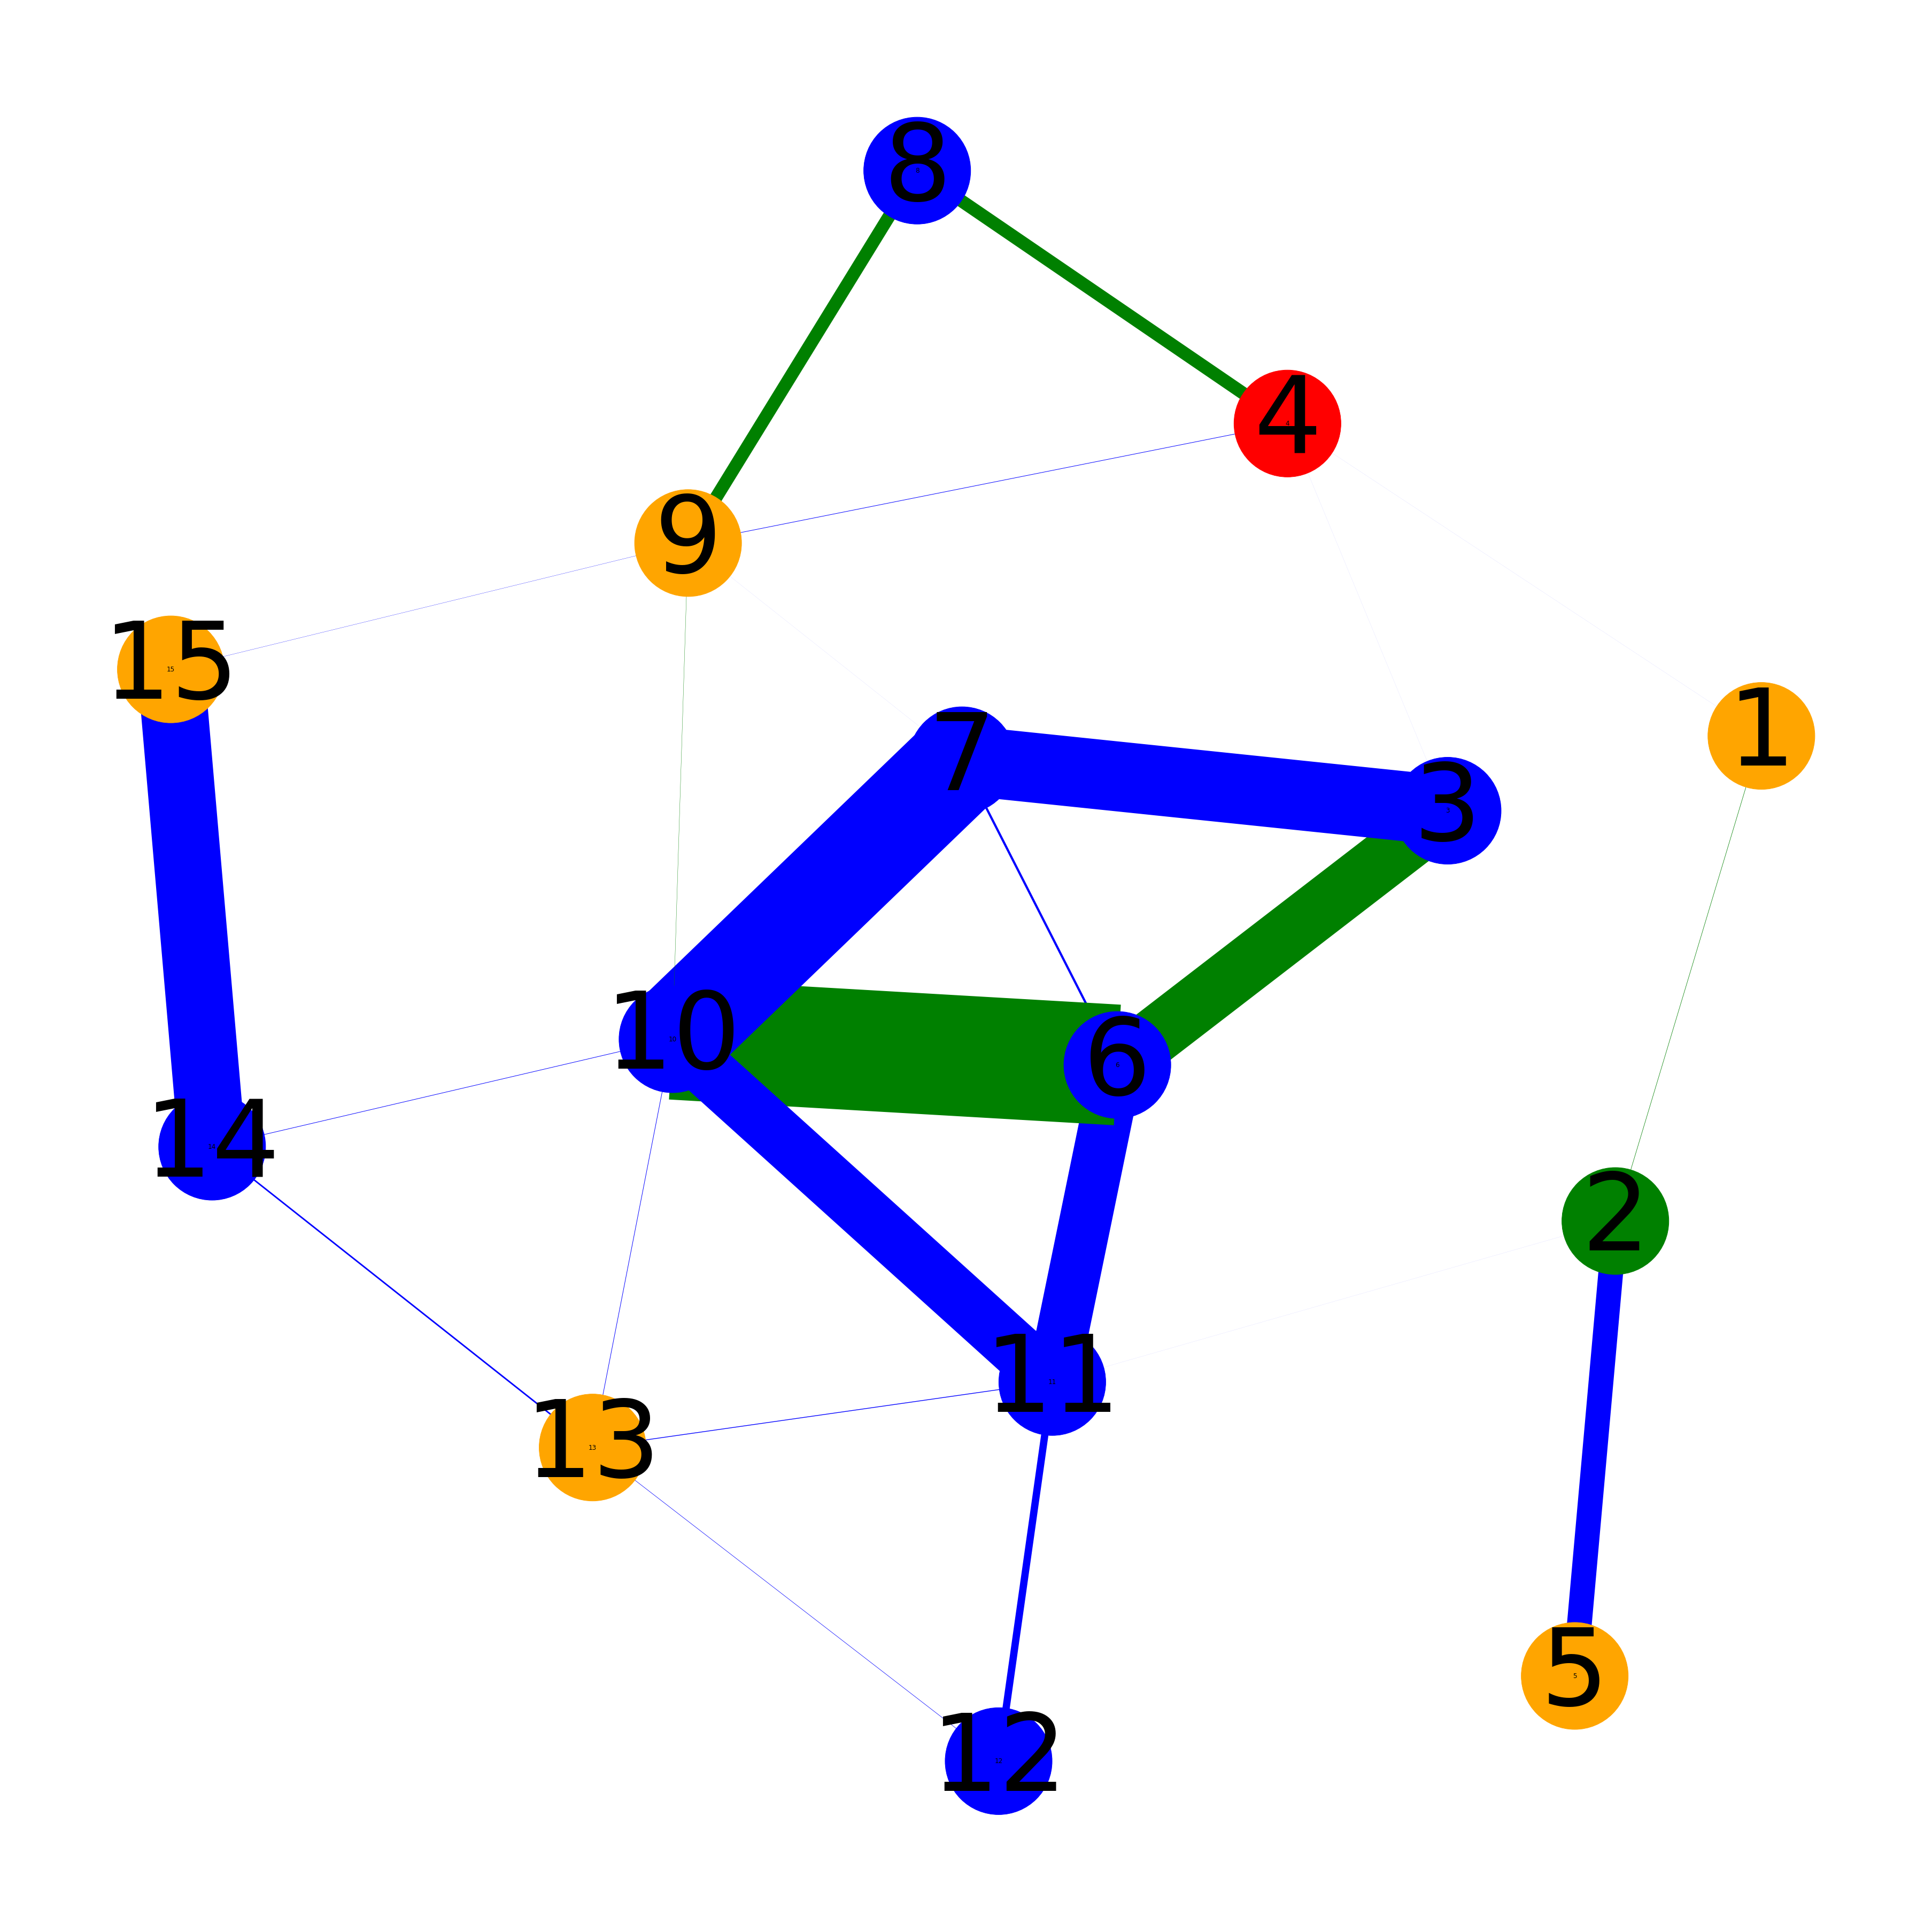

In [8]:
from matplotlib import pyplot as plt, animation
import networkx as nx
import random

plt.rcParams["figure.figsize"] = [50,50]
#plt.rcParams["figure.autolayout"] = True

fig = plt.figure()

#G = nx.DiGraph()
#G.add_nodes_from([0, 1, 2, 3, 4])
#nx.draw(G, with_labels=True)





def animate(frame):
    #fig = plt.figure(figsize=(100,100))
    fig.clear()
    for r in ROUTE_LIST:
        if r[-1]==False:
            break
    r[-1]=True
    demand=r[0]
    sd=r[1]
    route=r[2]
    G_copy=r[-2].copy()
    
    #num1 = random.randint(0, 4)
    #num2 = random.randint(0, 4)
    #G.add_edges_from([(num1, num2)])


    node_color_dict={}
    for i in G.nodes():
        node_color_dict[i]='b'
    node_color_dict[1]='orange'
    node_color_dict[5]='orange'
    node_color_dict[4]='orange'
    node_color_dict[13]='orange'
    node_color_dict[2]='orange'
    node_color_dict[9]='orange'
    node_color_dict[15]='orange'
    
    node_color_dict[sd[0]]='red'
    node_color_dict[sd[1]]='green'
#     for edge in route:
#         if edge in G_copy.edges():
#             G_copy[edge[0]][edge[1]]['capacity']-=demand
#         else:
#             G_copy[edge[1]][edge[0]]['capacity']-=demand
    for e in route:
        if e in G_copy.edges():
            G_copy[e[0]][e[1]]['color']='green'
        else:
            G_copy[e[1]][e[0]]['color']='green'
    pos = nx.kamada_kawai_layout(G_copy)
    edges = G_copy.edges()
    colors = [G_copy[u][v]['color'] for u,v in edges]
    weights = [G_copy[u][v]['capacity'] for u,v in edges]
    
    #plt.figure(3,figsize=(100,100)) 
    nx.draw(G_copy,pos,edge_color=colors, width=weights,with_labels=True,node_size=[40000]*len(G_copy.nodes),node_color=list(node_color_dict.values()))
    for node, (x, y) in pos.items():
        text(x, y, node, fontsize=200, ha='center', va='center')
    #nx.draw(G, with_labels=True)

ani = animation.FuncAnimation(fig, animate, frames=len(ROUTE_LIST), interval=1000)

ani.save('MIRASlow.mp4', writer = 'ffmpeg')

##### MHA Execute

In [9]:
def MHA(G,ab,D):
    G_temp=G.copy()
    G_temp_edge_list=list(G_temp.edges())
    for edge in G_temp_edge_list:
        if G_temp.get_edge_data(edge[0],edge[1])['capacity']<D:
            G_temp.remove_edge(edge[0],edge[1])
    for edge in G_temp.edges():
        G_temp[edge[0]][edge[1]]['capacity']=1
    try:
        shortest_path=nx.shortest_path(G_temp,ab[0],ab[1],weight='capacity')
    except:
        print("No Path Found from",ab[0],"to",ab[1])
        return G.copy(),0
    for i in range(len(shortest_path)-1):
        G[shortest_path[i]][shortest_path[i+1]]['capacity']-=D
    format_modified_shortest_path=[]
    for i in range(len(shortest_path)-1):
        l=[shortest_path[i],shortest_path[i+1]]
        format_modified_shortest_path.append(l)
#     for edge in G.edges():
#         print(G.get_edge_data(edge[0],edge[1])['capacity'])
    return G.copy(),format_modified_shortest_path


ROUTE_LIST=[]
G_copy=G.copy()
G_list_MHA=[]
flow_tracker={}
max_flow_tracker={}
node_traversal={}
for node in G.nodes():
    node_traversal[node]=0
for edge in G.edges():
    flow_tracker[edge]=[G[edge[0]][edge[1]]['capacity'],]
for iep in IEP:
    max_flow_tracker[tuple(iep)]=[]
    max_flow_tracker[tuple(iep)].append(nx.maximum_flow(G,iep[0],iep[1])[0])
rejection={}
for iep in IEP:
    rejection[tuple(iep)]=0
link_user={}
for edge in G.edges():
    link_user[edge]=0
link_user_by_IEP={}
for iep in IEP:
    link_user_by_IEP[tuple(iep)]=link_user.copy()    
path_length={}
for iep in IEP:
    path_length[tuple(iep)]=[]
accepted=0
not_accepted=0
for demand in range(4000):
    G_copy,R=MHA(G_copy.copy(),IEP[PAIR[demand]],DEMAND[demand])
    flow_decrease_on_links(flow_tracker,R,G_copy)
    max_flow_decrease(G_copy,max_flow_tracker,IEP)
    if R==0:
        
        not_accepted+=1
        rejection[tuple(IEP[PAIR[demand]])]+=1
    else:
        G_list_MHA.append((G_copy.copy(),R,IEP[PAIR[demand]],DEMAND[demand]))
        ROUTE_LIST.append([DEMAND[demand],tuple(IEP[PAIR[demand]]),R,G_copy.copy()])
        link_usage(link_user,link_user_by_IEP,R,G,IEP[PAIR[demand]])
        accepted+=1
        path_length[tuple(IEP[PAIR[demand]])].append(len(R))
        router_traversal(node_traversal,R)
for keys in path_length.keys():
    path_length[keys]=sum(path_length[keys])/len(path_length[keys])
        
print("MHA")
print("ACCEPTED!!!!",accepted)
print("NOT ACCEPTED!!!",not_accepted)

for R in ROUTE_LIST:
    for i in range(len(R[2])):
        R[2][i]=tuple(R[2][i])
for r in ROUTE_LIST:
    r.append(False)

No Path Found from 1 to 13
No Path Found from 1 to 13
No Path Found from 1 to 13
No Path Found from 1 to 13
No Path Found from 1 to 13
No Path Found from 1 to 13
No Path Found from 1 to 13
No Path Found from 1 to 13
No Path Found from 1 to 13
No Path Found from 1 to 13
No Path Found from 1 to 13
No Path Found from 1 to 13
No Path Found from 1 to 13
No Path Found from 1 to 13
No Path Found from 1 to 13
No Path Found from 1 to 13
No Path Found from 1 to 13
No Path Found from 1 to 13
No Path Found from 1 to 13
No Path Found from 1 to 13
No Path Found from 1 to 13
No Path Found from 1 to 13
No Path Found from 1 to 13
No Path Found from 1 to 13
No Path Found from 1 to 13
No Path Found from 1 to 13
No Path Found from 1 to 13
No Path Found from 1 to 13
No Path Found from 1 to 13
No Path Found from 1 to 13
No Path Found from 1 to 13
No Path Found from 1 to 13
No Path Found from 1 to 13
No Path Found from 1 to 13
No Path Found from 1 to 13
No Path Found from 1 to 13
No Path Found from 1 to 13
N

No Path Found from 1 to 13
No Path Found from 13 to 2
No Path Found from 1 to 13
No Path Found from 13 to 2
No Path Found from 13 to 2
No Path Found from 13 to 2
No Path Found from 13 to 2
No Path Found from 1 to 13
No Path Found from 1 to 13
No Path Found from 1 to 13
No Path Found from 1 to 13
No Path Found from 1 to 13
No Path Found from 1 to 13
No Path Found from 1 to 13
No Path Found from 1 to 13
No Path Found from 1 to 13
No Path Found from 1 to 13
No Path Found from 13 to 2
No Path Found from 1 to 13
No Path Found from 1 to 13
No Path Found from 13 to 2
No Path Found from 13 to 2
No Path Found from 13 to 2
No Path Found from 13 to 2
No Path Found from 13 to 2
No Path Found from 1 to 13
No Path Found from 1 to 13
No Path Found from 1 to 13
No Path Found from 1 to 13
No Path Found from 13 to 2
No Path Found from 13 to 2
No Path Found from 13 to 2
No Path Found from 13 to 2
No Path Found from 1 to 13
No Path Found from 1 to 13
No Path Found from 1 to 13
No Path Found from 13 to 2
N

##### MHA Animation

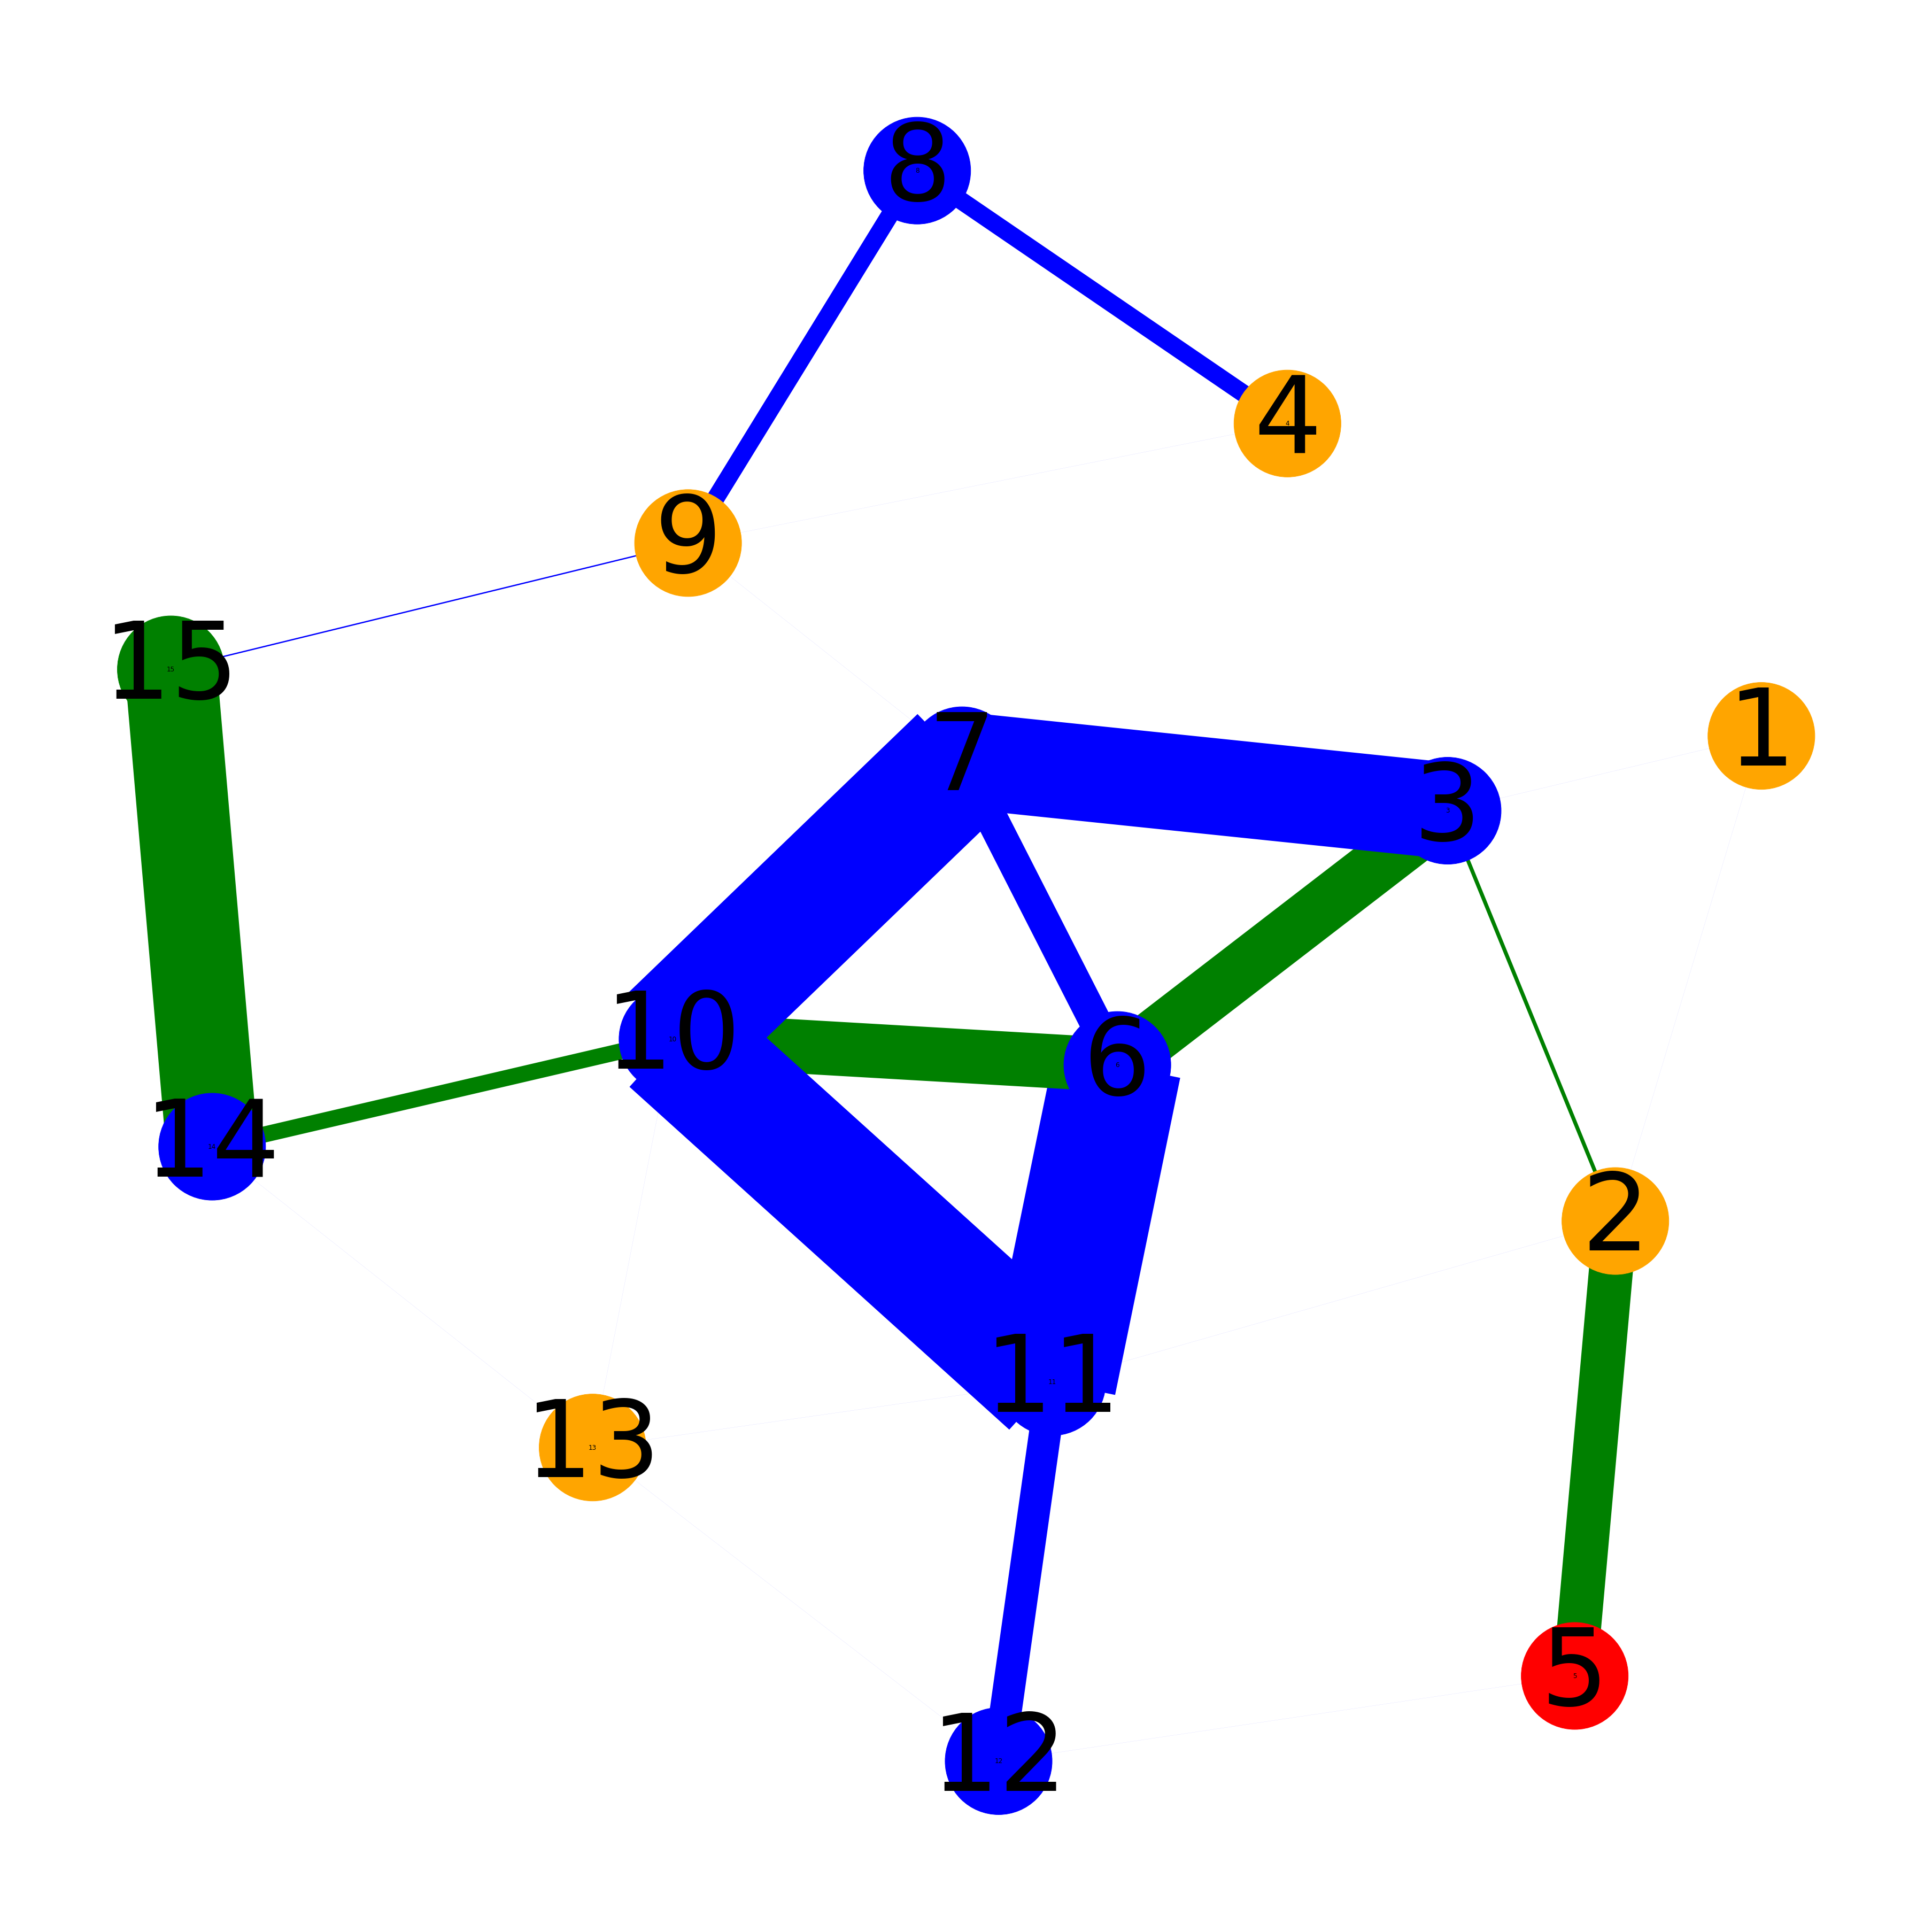

In [10]:
from matplotlib import pyplot as plt, animation
import networkx as nx
import random

plt.rcParams["figure.figsize"] = [50,50]
#plt.rcParams["figure.autolayout"] = True

fig = plt.figure()

#G = nx.DiGraph()
#G.add_nodes_from([0, 1, 2, 3, 4])
#nx.draw(G, with_labels=True)





def animate(frame):
    #fig = plt.figure(figsize=(100,100))
    fig.clear()
    for r in ROUTE_LIST:
        if r[-1]==False:
            break
    r[-1]=True
    demand=r[0]
    sd=r[1]
    route=r[2]
    G_copy=r[-2].copy()
    
    #num1 = random.randint(0, 4)
    #num2 = random.randint(0, 4)
    #G.add_edges_from([(num1, num2)])


    node_color_dict={}
    for i in G.nodes():
        node_color_dict[i]='b'
    node_color_dict[1]='orange'
    node_color_dict[5]='orange'
    node_color_dict[4]='orange'
    node_color_dict[13]='orange'
    node_color_dict[2]='orange'
    node_color_dict[9]='orange'
    node_color_dict[15]='orange'
    
    node_color_dict[sd[0]]='red'
    node_color_dict[sd[1]]='green'
#     for edge in route:
#         if edge in G_copy.edges():
#             G_copy[edge[0]][edge[1]]['capacity']-=demand
#         else:
#             G_copy[edge[1]][edge[0]]['capacity']-=demand
    for e in route:
        if e in G_copy.edges():
            G_copy[e[0]][e[1]]['color']='green'
        else:
            G_copy[e[1]][e[0]]['color']='green'
    pos = nx.kamada_kawai_layout(G_copy)
    edges = G_copy.edges()
    colors = [G_copy[u][v]['color'] for u,v in edges]
    weights = [G_copy[u][v]['capacity'] for u,v in edges]
    
    #plt.figure(3,figsize=(100,100)) 
    nx.draw(G_copy,pos,edge_color=colors, width=weights,with_labels=True,node_size=[40000]*len(G_copy.nodes),node_color=list(node_color_dict.values()))
    for node, (x, y) in pos.items():
        text(x, y, node, fontsize=200, ha='center', va='center')
    #nx.draw(G, with_labels=True)

ani = animation.FuncAnimation(fig, animate, frames=len(ROUTE_LIST), interval=1000)

ani.save('MHASlow.mp4', writer = 'ffmpeg')